In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
import itertools
from functools import partial
import pdb

2023-03-20 15:58:39.800379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 15:58:40.056844: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-20 15:58:40.973137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-20 15:58:40.973491: W ten

In [15]:
import scipy.stats as stats

def draw_custom_pairplot(df):
    grd = sns.pairplot(
        df,
        kind="reg",
        corner=False,
        diag_kind="kde",
        plot_kws={
            "line_kws": {"color": "black"},  # "#440154"},
            "scatter_kws": {
                "alpha": 0.4,
            },
        },
    )


    def hide_plots(x, y, **kwargs):
        ax = plt.gca()
        ax.clear()
        ax.tick_params(
            axis="x",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.tick_params(
            axis="y",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.set_frame_on(True)


    num_comparisons = 1  # 9 * 9 / 2


    def summary(x, y, **kwargs):
        correlation, pvalue = stats.pearsonr(x, y)
        corr_str = "%.3f" % round(correlation, 3)
        # Bonferroni correction
        pval_str = "%.3f" % round(pvalue / num_comparisons, 3)
        label = f"corr: {corr_str}\np-val: {pval_str}"

        ax = plt.gca()
        # ax.set_axis_off()
        ax.annotate(
            label,
            xy=(0.15, 0.4),
            size=20,
            xycoords=ax.transAxes,
            color="#440154",
        )


    sns.set(font_scale=2.5)
    for ax in grd.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=30, fontsize=22)
        # rotate y axis labels
        ax.set_ylabel(
            ax.get_ylabel(),
            rotation=30,
            fontsize=22,
            labelpad = 100,
            loc='bottom'
            # horizontalalignment="center",
            # verticalalignment="center",
        )


    grd = grd.map_upper(hide_plots)
    grd = grd.map_upper(summary)
    # grd = grd.map_lower(sns.kdeplot, cmap="viridis")
    fig = plt.figure()
    fig.align_labels()
    plt.show()


In [7]:
import json
f = open('/home/yitongt/ml_phage/hyperparam_output.json')
json_experiments = json.load(f)
import pandas as pd
import seaborn as sn
df = pd.DataFrame(json_experiments)
df = df.drop(columns=['all_combined_auc', 'all_just_er_auc', 'all_just_pval_auc', 'all_just_fc_auc'])



AttributeError: 'Line2D' object has no property 'cmap'

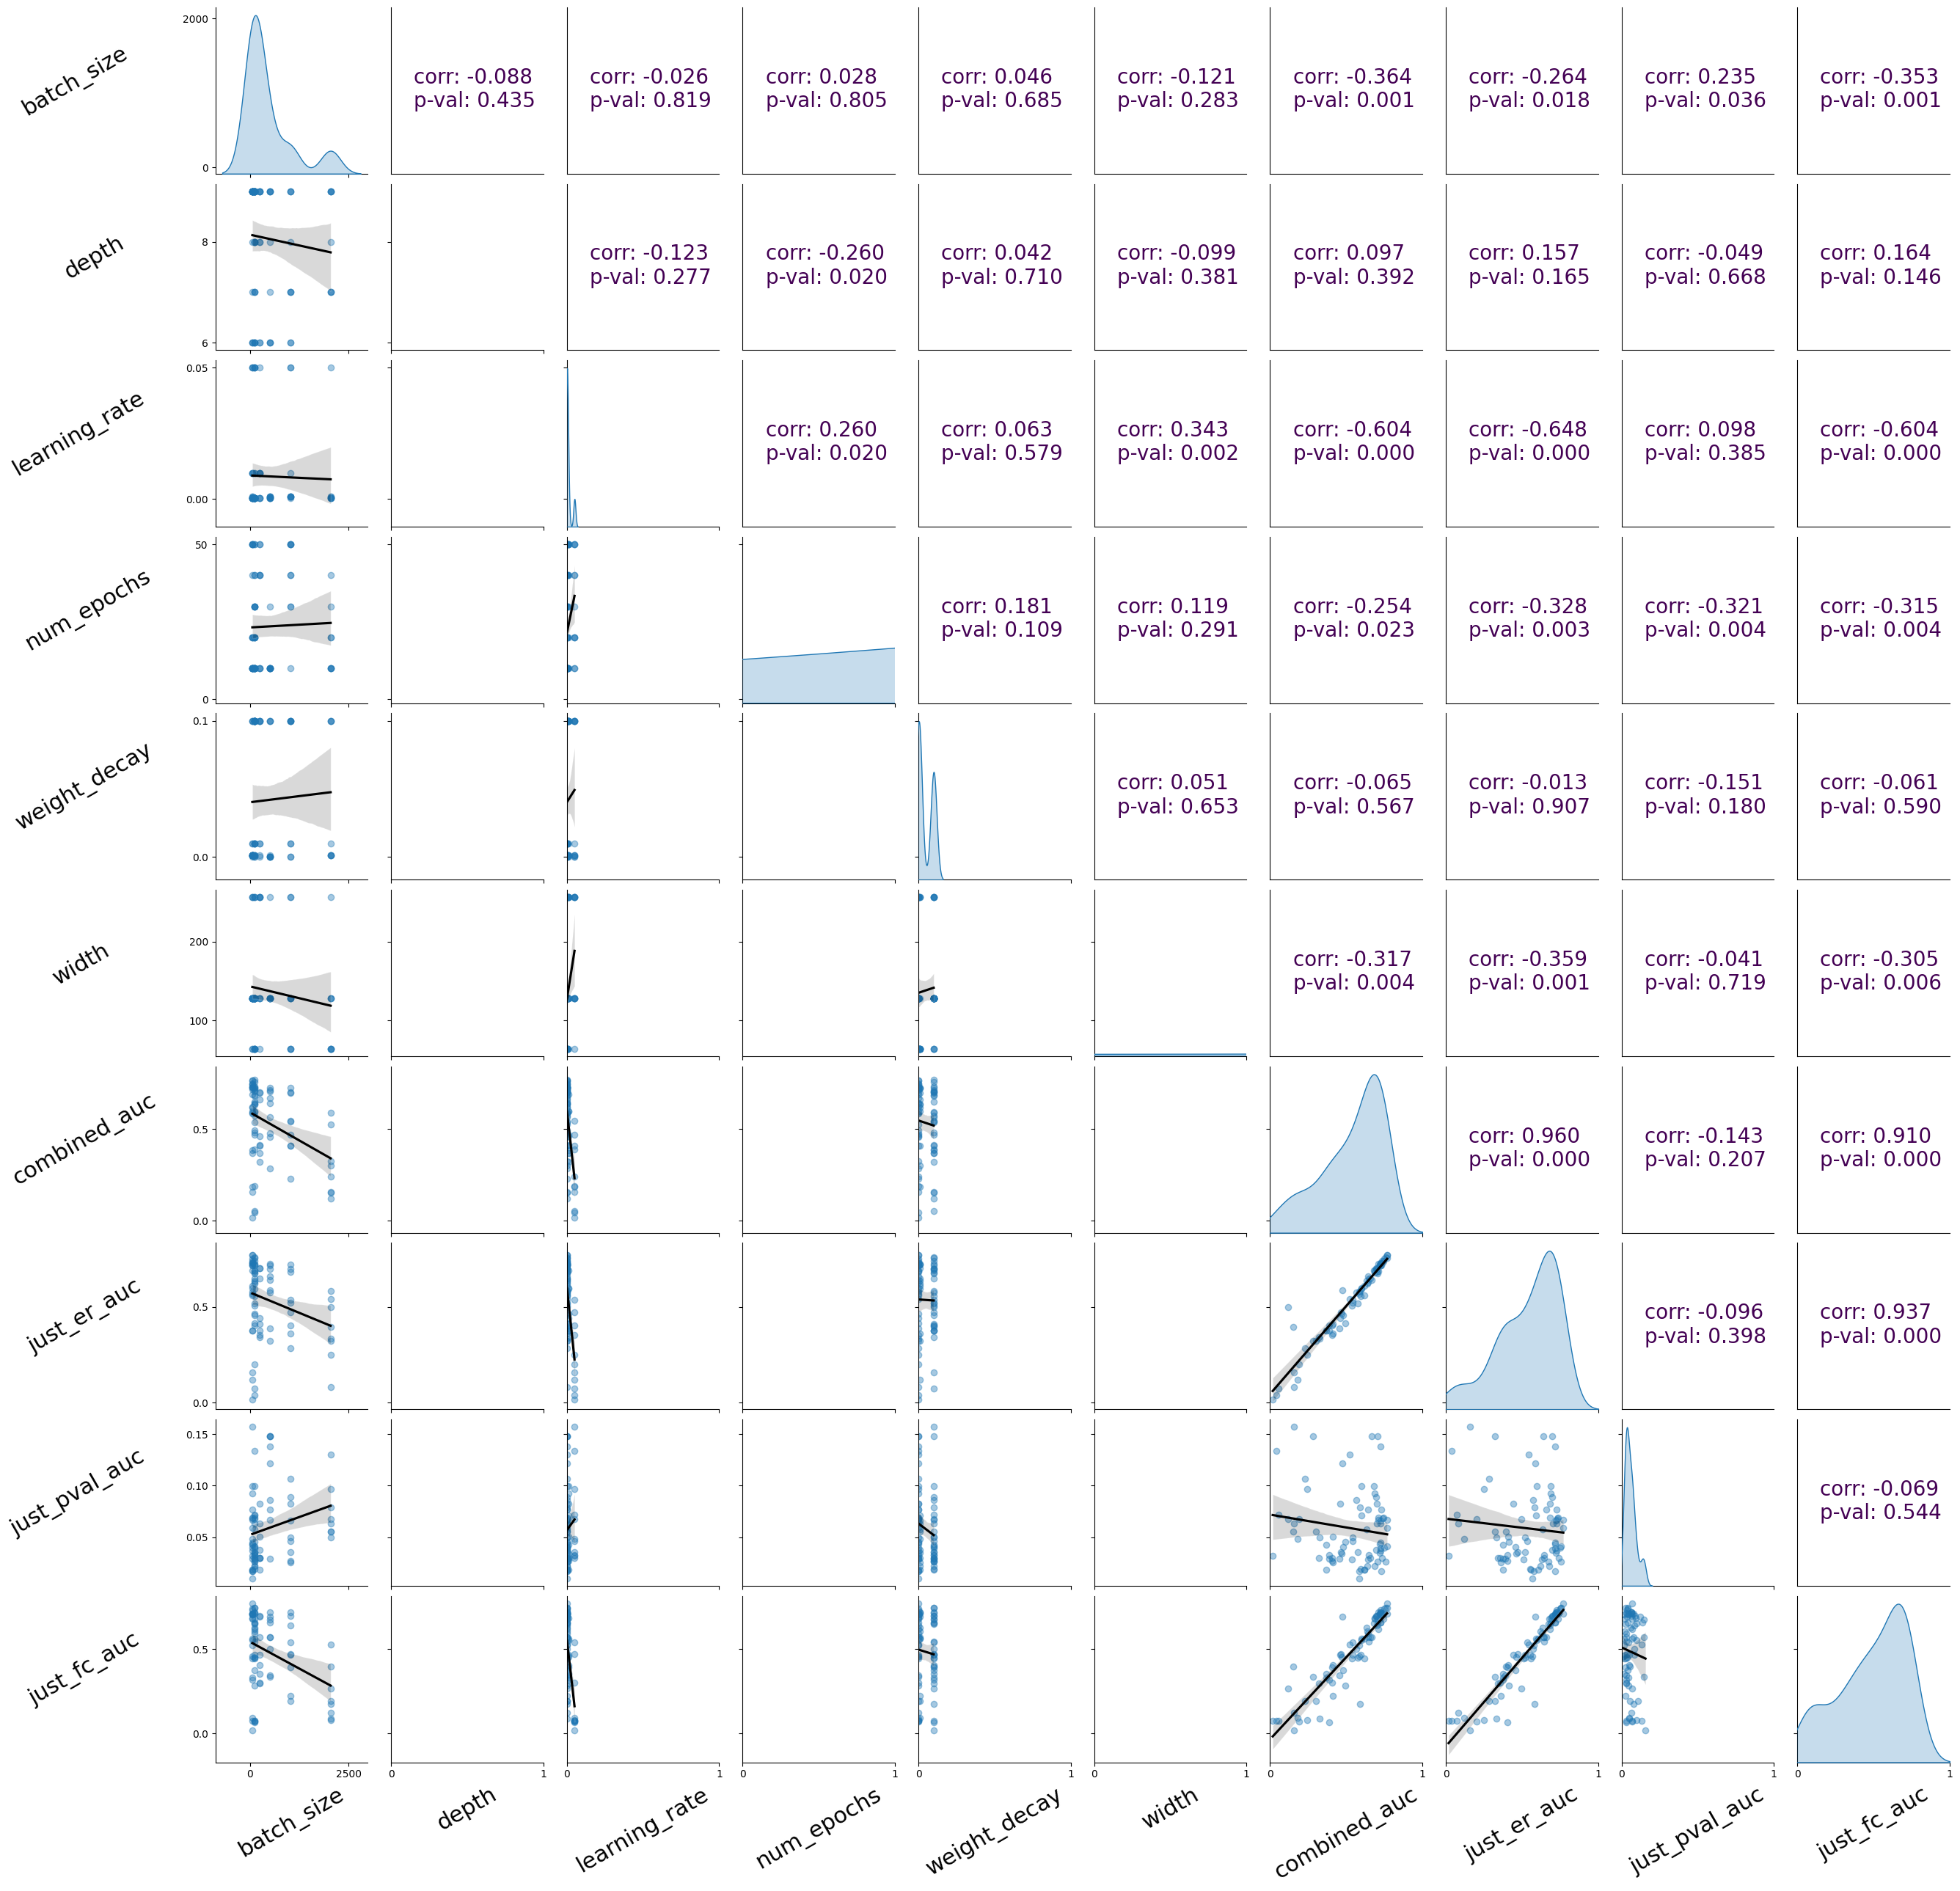

In [16]:
draw_custom_pairplot(df)

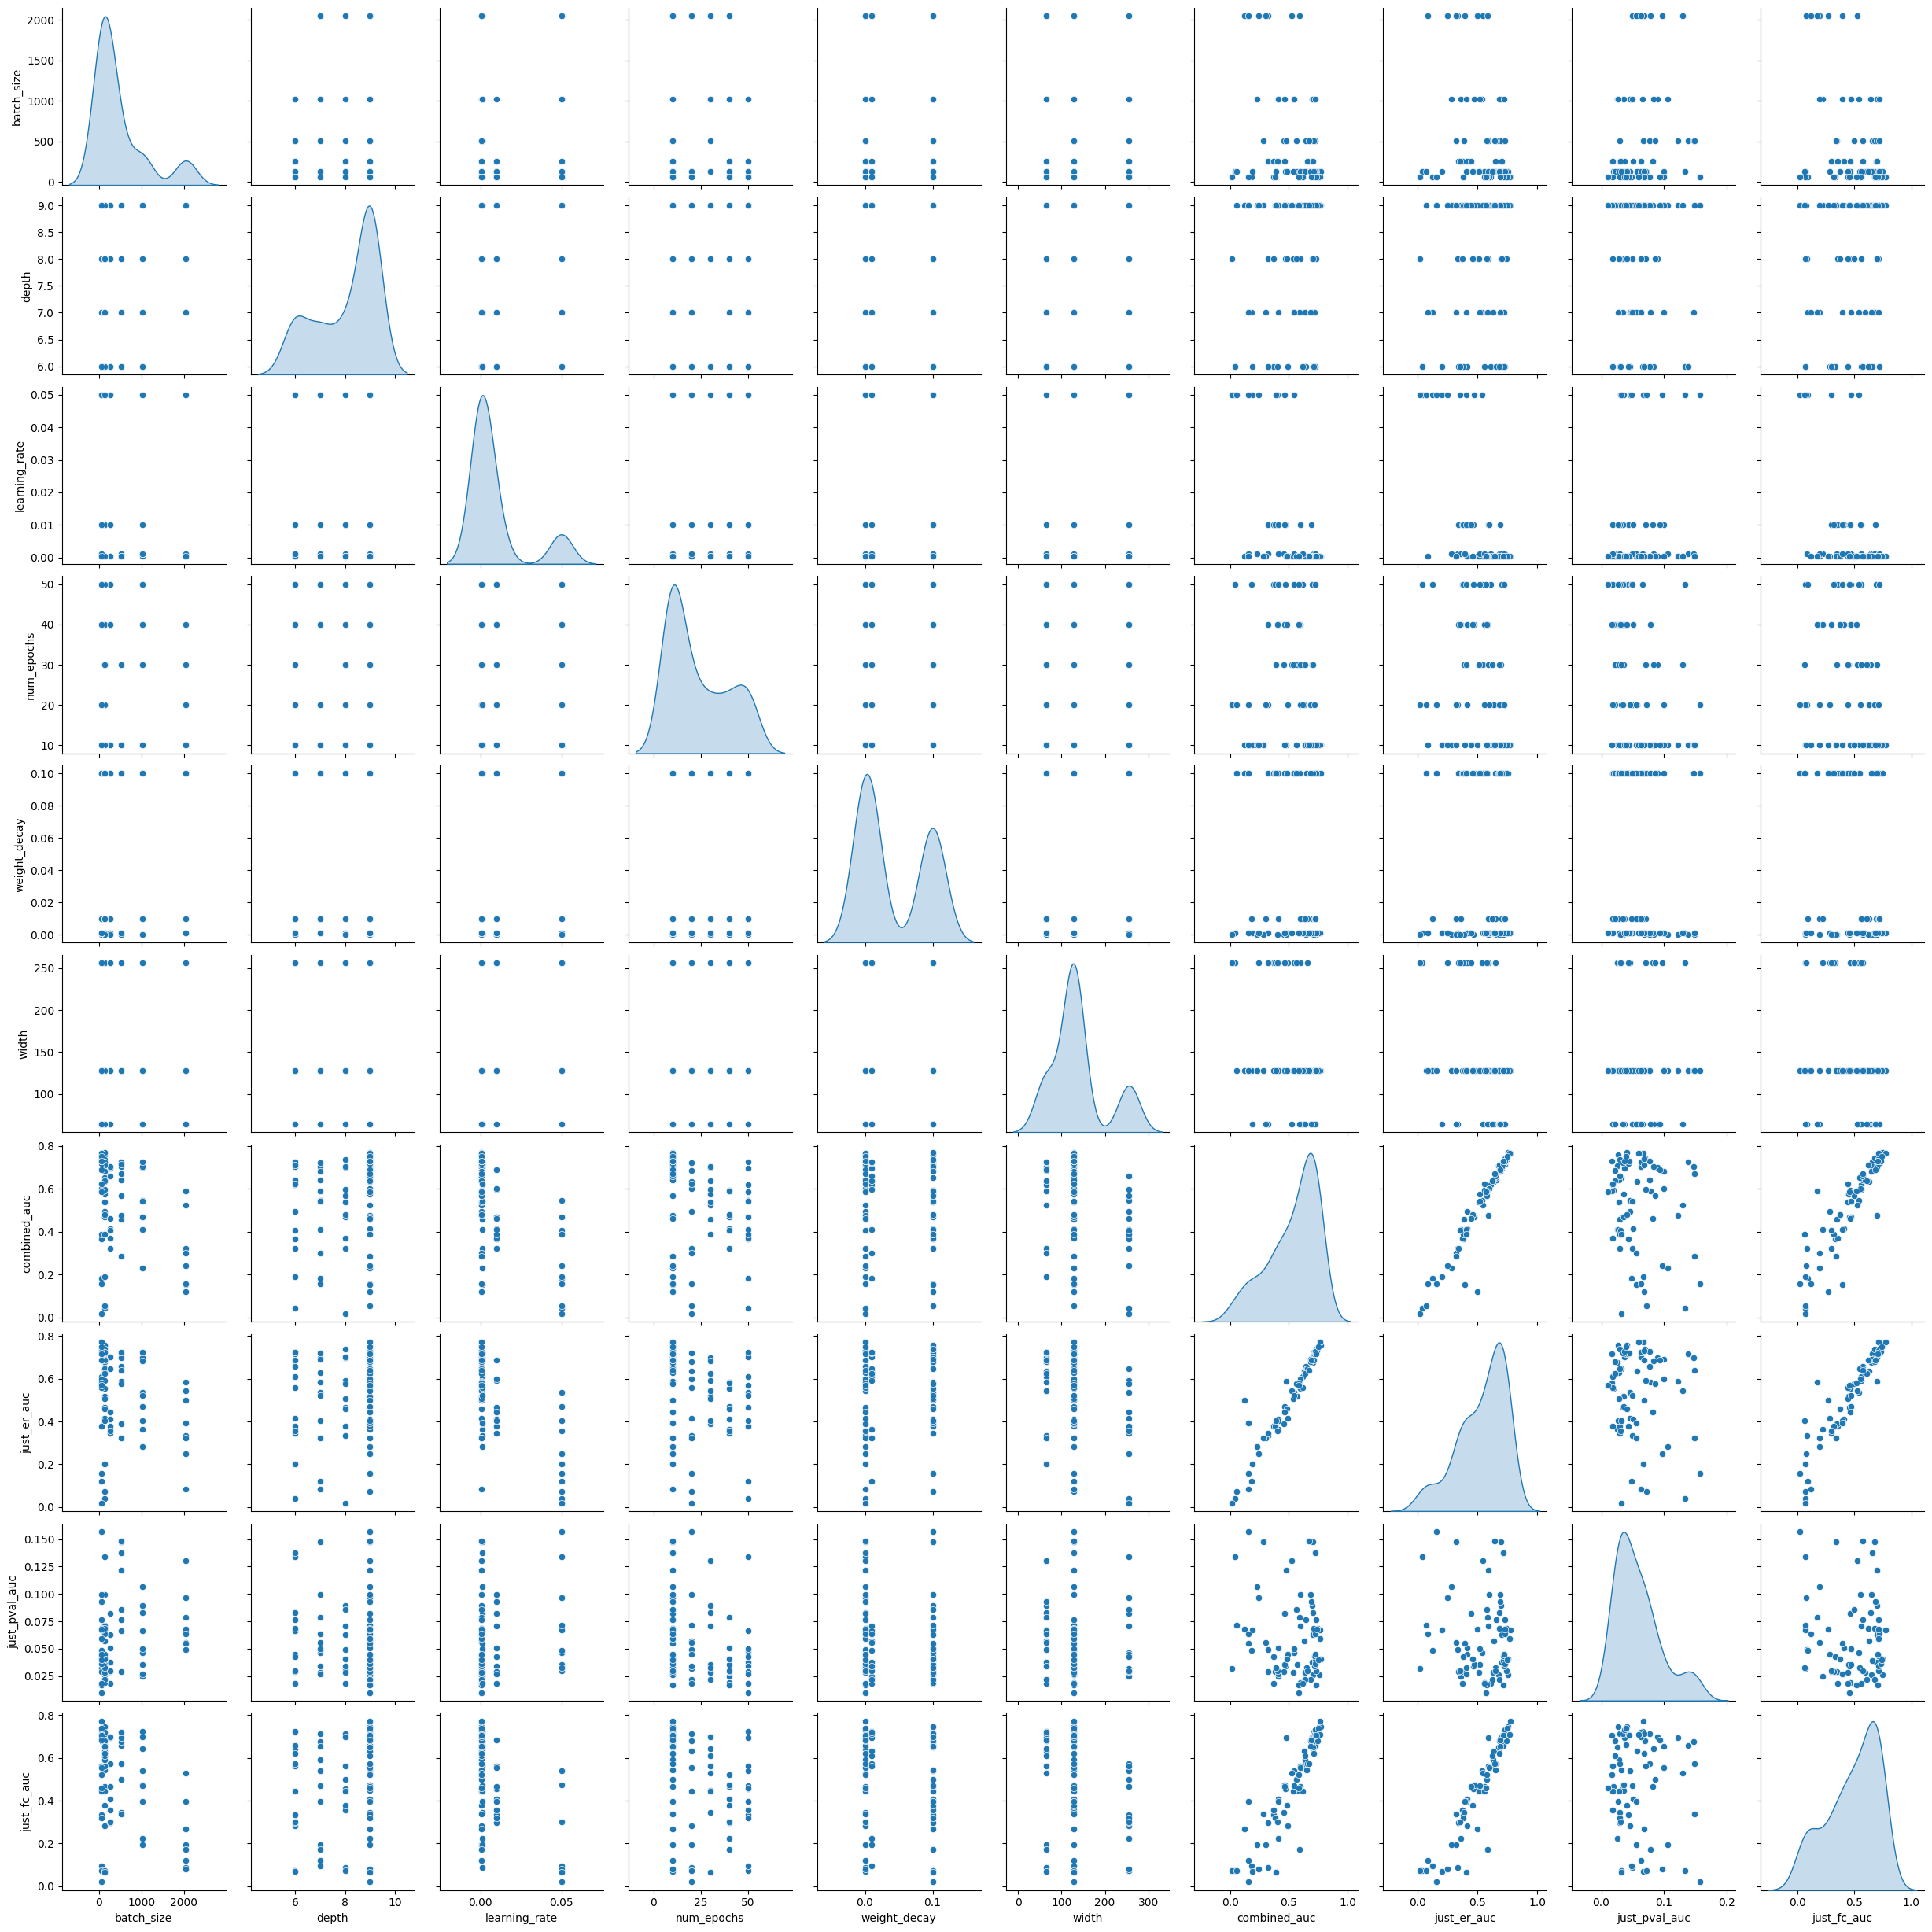

In [14]:
sn.pairplot(df, diag_kind="kde")


In [2]:
permutation = {
    "width": 128,  # 32, 
    "depth": 7, 
    "batch_size": 128,
    "weight_decay": 0,
    "learning_rate": 0.001,
    "num_epochs": 10
}
protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)

(X_eval, X, y_eval, y_raw, peptides_eval, peptides) = train_test_split(
    X,
    y_raw,
    peptides,
    test_size=0.5,
    shuffle=True,
    random_state=5,
)

def benchmark(mdm2_result, X, peptides, pred_ranking):
    mdm2_model = mdm2_result.trained_model
    return plot_ratio_by_ranking(
        peptides=peptides,
        ca5_y_ranking=None,
        mdm2_y_ranking=[pred_ranking(pred) for pred in mdm2_model(X)],
        title="",
        plot_theoretical_maximums=True,
        plot=False
    )
mdm2_results = experiment.Experiment().run_cross_validation_experiment(
    X,
    y_raw,
    partial(
        rnn.ThreeChannelRegressionRNN_gelu, depth=permutation["depth"], width=permutation["width"]
    ),
    model_save_name=f"grid_search_models/learning_rate({permutation['learning_rate']})_batch_size({permutation['batch_size']})_depth({permutation['depth']})_width({permutation['width']})_weightdecay({permutation['weight_decay']}).h5",
    normalize=True,
    n_splits=2,
    batch_size=permutation["batch_size"],
    optimizer=partial(keras.optimizers.Adam, learning_rate=permutation['learning_rate'], weight_decay=permutation["weight_decay"]), 
    num_epochs=permutation['num_epochs']
)

permutation['all_combined_auc'] = [benchmark(mdm2_result, X, peptides, lambda x: x[0] + x[1] + x[2]) for mdm2_result in mdm2_results]
permutation['all_just_er_auc'] = [benchmark(mdm2_result, X, peptides, lambda x: x[2]) for mdm2_result in mdm2_results]
permutation['all_just_pval_auc'] = [benchmark(mdm2_result, X, peptides, lambda x: x[0]) for mdm2_result in mdm2_results]
permutation['all_just_fc_auc'] = [benchmark(mdm2_result, X, peptides, lambda x: x[1]) for mdm2_result in mdm2_results]

permutation['combined_auc'] = np.max(permutation['all_combined_auc'])
permutation['just_er_auc'] = np.max(permutation['all_just_er_auc'])
permutation['just_pval_auc'] = np.max(permutation['all_just_pval_auc'])
permutation['just_fc_auc'] = np.max(permutation['all_just_fc_auc'])



/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


Epoch 1/10
65/65 [==============================] - 13s 186ms/step - loss: 0.8520 - multi_channel_mse: 0.8520 - fold_rmse: 0.8364 - p_value_rmse: 0.8127 - er_rmse: 0.9024 - lr: 0.0010
Epoch 2/10
65/65 [==============================] - 12s 180ms/step - loss: 0.7662 - multi_channel_mse: 0.7662 - fold_rmse: 0.7536 - p_value_rmse: 0.7065 - er_rmse: 0.8332 - lr: 0.0010
Epoch 3/10
65/65 [==============================] - 11s 175ms/step - loss: 0.7492 - multi_channel_mse: 0.7492 - fold_rmse: 0.7334 - p_value_rmse: 0.6966 - er_rmse: 0.8178 - lr: 0.0010
Epoch 4/10
65/65 [==============================] - 12s 178ms/step - loss: 0.7333 - multi_channel_mse: 0.7333 - fold_rmse: 0.7218 - p_value_rmse: 0.6806 - er_rmse: 0.8025 - lr: 0.0010
Epoch 5/10
65/65 [==============================] - 11s 176ms/step - loss: 0.7206 - multi_channel_mse: 0.7206 - fold_rmse: 0.7078 - p_value_rmse: 0.6733 - er_rmse: 0.7917 - lr: 0.0010
Epoch 6/10
65/65 [==============================] - 12s 179ms/step - loss: 0.712

INFO:tensorflow:Assets written to: grid_search_models/learning_rate(0.001)_batch_size(128)_depth(7)_width(128)_weightdecay(0).h50/assets


INFO:tensorflow:Assets written to: grid_search_models/learning_rate(0.001)_batch_size(128)_depth(7)_width(128)_weightdecay(0).h50/assets


65/65 [==============================] - 21s 318ms/step - loss: 0.6868 - multi_channel_mse: 0.6868 - fold_rmse: 0.6608 - p_value_rmse: 0.6439 - er_rmse: 0.7563 - lr: 6.0653e-04


Epoch 1/10
65/65 [==============================] - 12s 185ms/step - loss: 0.8853 - multi_channel_mse: 0.8853 - fold_rmse: 0.8982 - p_value_rmse: 0.8310 - er_rmse: 0.9258 - lr: 0.0010
Epoch 2/10
65/65 [==============================] - 12s 185ms/step - loss: 0.7987 - multi_channel_mse: 0.7987 - fold_rmse: 0.7885 - p_value_rmse: 0.7426 - er_rmse: 0.8591 - lr: 0.0010
Epoch 3/10
65/65 [==============================] - 12s 177ms/step - loss: 0.7732 - multi_channel_mse: 0.7732 - fold_rmse: 0.7611 - p_value_rmse: 0.7177 - er_rmse: 0.8426 - lr: 0.0010
Epoch 4/10
65/65 [==============================] - 12s 181ms/step - loss: 0.7644 - multi_channel_mse: 0.7644 - fold_rmse: 0.7477 - p_value_rmse: 0.7086 - er_rmse: 0.8294 - lr: 0.0010
Epoch 5/10
65/65 [==============================] - 12s 180ms/step - loss: 0.7548 - multi_channel_mse: 0.7548 - fold_rmse: 0.7421 - p_value_rmse: 0.7027 - er_rmse: 0.8241 - lr: 0.0010
Epoch 6/10
65/65 [==============================] - 12s 180ms/step - loss: 0.749

INFO:tensorflow:Assets written to: grid_search_models/learning_rate(0.001)_batch_size(128)_depth(7)_width(128)_weightdecay(0).h51/assets


INFO:tensorflow:Assets written to: grid_search_models/learning_rate(0.001)_batch_size(128)_depth(7)_width(128)_weightdecay(0).h51/assets


65/65 [==============================] - 20s 309ms/step - loss: 0.7222 - multi_channel_mse: 0.7222 - fold_rmse: 0.6978 - p_value_rmse: 0.6747 - er_rmse: 0.7985 - lr: 6.0653e-04
MDM2 area under curve:  1.3070868794098718
normalized MDM2 area under curve:  0.0026450741037007154
MDM2 area under curve:  16.54565144810981
normalized MDM2 area under curve:  0.03348245236308427
MDM2 area under curve:  1.4724786473780354
normalized MDM2 area under curve:  0.002979767603657948
MDM2 area under curve:  14.974719771855051
normalized MDM2 area under curve:  0.030303451210979798
MDM2 area under curve:  32.7369909836488
normalized MDM2 area under curve:  0.06624790474756201
MDM2 area under curve:  48.7208121192311
normalized MDM2 area under curve:  0.09859341446838554
MDM2 area under curve:  22.154805588784562
normalized MDM2 area under curve:  0.04483336452881798
MDM2 area under curve:  15.284559843532522
normalized MDM2 area under curve:  0.03093045616588598


MDM2 area under curve:  10.63507255838109
normalized MDM2 area under curve:  0.02127014511676218


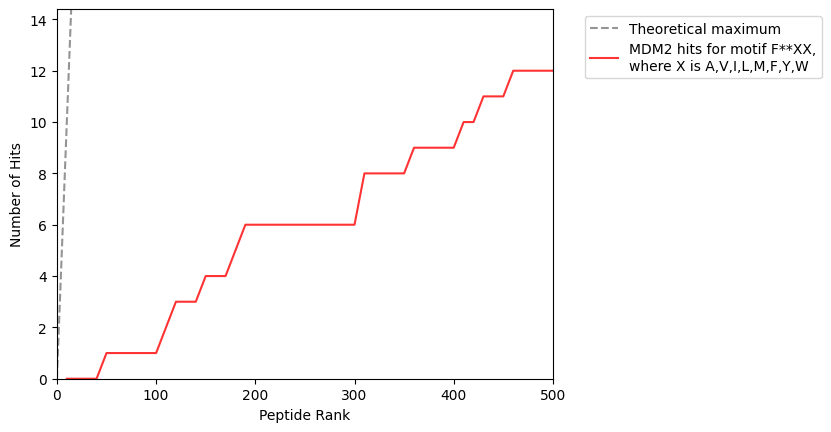

0.02127014511676218

In [11]:
from src.analysis.hit_rate_analysis import sort_peptides_by_model_ranking



permutation
mdm2_results
mdm2_model = mdm2_results[0].trained_model
pred_ranking = lambda x: x[0] + x[1] + x[2]
plot_ratio_by_ranking(
    peptides=peptides,
    ca5_y_ranking=None,
    mdm2_y_ranking=[pred_ranking(pred).numpy()  for pred in mdm2_model(X)],
    title="",
    plot_theoretical_maximums=True,
    plot=True
)


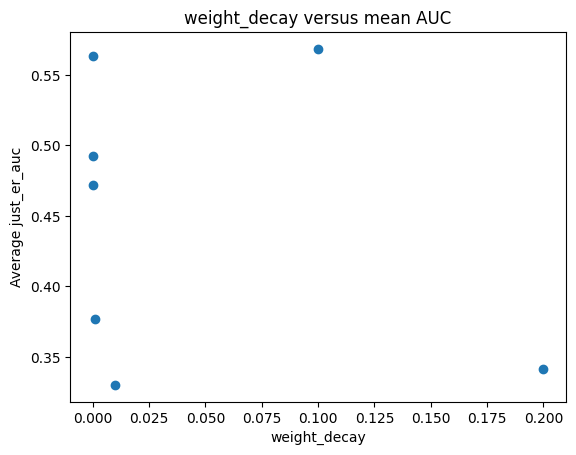

In [17]:
import numpy as np
import matplotlib.pyplot as plt
hyper_param_outputs = [{'param_power': 4.5, 'weight_decay': 0, 'combined_auc': 0.5652755786846201, 'just_er_auc': 0.5783400459412489, 'just_pval_auc': 0.03408629438149774, 'just_fc_auc': 0.5844071668754205}, {'param_power': 4.5, 'weight_decay': 1e-05, 'combined_auc': 0.24980570872851635, 'just_er_auc': 0.33645815827227077, 'just_pval_auc': 0.08466689999148784, 'just_fc_auc': 0.24610263442088554}, {'param_power': 4.5, 'weight_decay': 0.0001, 'combined_auc': 0.4808753058241902, 'just_er_auc': 0.45135320099293363, 'just_pval_auc': 0.06662809160613933, 'just_fc_auc': 0.004807226903029655}, {'param_power': 4.5, 'weight_decay': 0.001, 'combined_auc': 0.14897606976248615, 'just_er_auc': 0.17006751069102055, 'just_pval_auc': 0.06888148158826418, 'just_fc_auc': 0.0323359183999475}, {'param_power': 4.5, 'weight_decay': 0.01, 'combined_auc': 0.04551249695411482, 'just_er_auc': 0.04352938274342759, 'just_pval_auc': 0.036779057300230615, 'just_fc_auc': 0.06430297736526024}, {'param_power': 4.5, 'weight_decay': 0.1, 'combined_auc': 0.31958511677282503, 'just_er_auc': 0.29245873652921467, 'just_pval_auc': 0.042451914860300394, 'just_fc_auc': 0.034449850251940306}, {'param_power': 4.5, 'weight_decay': 0.2, 'combined_auc': 0.04273523770957426, 'just_er_auc': 0.07342615066610474, 'just_pval_auc': 0.037714067477927986, 'just_fc_auc': 0.13449900683151375}, {'param_power': 5, 'weight_decay': 0, 'combined_auc': 0.49592857797808526, 'just_er_auc': 0.4418764481875688, 'just_pval_auc': 0.041944038701237626, 'just_fc_auc': 0.4051181768845295}, {'param_power': 5, 'weight_decay': 1e-05, 'combined_auc': 0.0965195337675406, 'just_er_auc': 0.08595953569132678, 'just_pval_auc': 0.024646875262771217, 'just_fc_auc': 0.044107709641889044}, {'param_power': 5, 'weight_decay': 0.0001, 'combined_auc': 0.6253562657751756, 'just_er_auc': 0.6330131492396501, 'just_pval_auc': 0.014037877471312608, 'just_fc_auc': 0.5472734198752095}, {'param_power': 5, 'weight_decay': 0.001, 'combined_auc': 0.7181643508210375, 'just_er_auc': 0.7113951918431204, 'just_pval_auc': 0.03800144252168448, 'just_fc_auc': 0.7132776345457953}, {'param_power': 5, 'weight_decay': 0.01, 'combined_auc': 0.5538419083045777, 'just_er_auc': 0.5447792423595775, 'just_pval_auc': 0.01949644868441525, 'just_fc_auc': 0.4904439314381942}, {'param_power': 5, 'weight_decay': 0.1, 'combined_auc': 0.6836523872655038, 'just_er_auc': 0.6765792198611721, 'just_pval_auc': 0.04190016074599482, 'just_fc_auc': 0.6765394500394762}, {'param_power': 5, 'weight_decay': 0.2, 'combined_auc': 0.34618037791519884, 'just_er_auc': 0.3058892642520422, 'just_pval_auc': 0.02935573280508282, 'just_fc_auc': 0.035349471227080084}, {'param_power': 5.5, 'weight_decay': 0, 'combined_auc': 0.7240688933944047, 'just_er_auc': 0.7291771255180931, 'just_pval_auc': 0.022514846860773374, 'just_fc_auc': 0.7225460860123436}, {'param_power': 5.5, 'weight_decay': 1e-05, 'combined_auc': 0.7357883726191353, 'just_er_auc': 0.7347371449873976, 'just_pval_auc': 0.032505771648828403, 'just_fc_auc': 0.7316262138650079}, {'param_power': 5.5, 'weight_decay': 0.0001, 'combined_auc': 0.6065350447571334, 'just_er_auc': 0.6062624272216355, 'just_pval_auc': 0.021441948301867488, 'just_fc_auc': 0.5980749377414305}, {'param_power': 5.5, 'weight_decay': 0.001, 'combined_auc': 0.19014065596083274, 'just_er_auc': 0.1452600449049513, 'just_pval_auc': 0.008674873352980552, 'just_fc_auc': 0.019408425963274994}, {'param_power': 5.5, 'weight_decay': 0.01, 'combined_auc': 0.14768753385936906, 'just_er_auc': 0.15910265932688725, 'just_pval_auc': 0.060289787237170274, 'just_fc_auc': 0.04930659148465093}, {'param_power': 5.5, 'weight_decay': 0.1, 'combined_auc': 0.5438043232610091, 'just_er_auc': 0.5614648558733503, 'just_pval_auc': 0.011825073393829644, 'just_fc_auc': 0.5355086644358331}, {'param_power': 5.5, 'weight_decay': 0.2, 'combined_auc': 0.11942413903259033, 'just_er_auc': 0.10637621366306715, 'just_pval_auc': 0.03345700340889553, 'just_fc_auc': 0.05573246918951244}, {'param_power': 6, 'weight_decay': 0, 'combined_auc': 0.7515634289734184, 'just_er_auc': 0.7430009746128303, 'just_pval_auc': 0.023095170822632353, 'just_fc_auc': 0.7315670785648248}, {'param_power': 6, 'weight_decay': 1e-05, 'combined_auc': 0.6984148841048129, 'just_er_auc': 0.6981544569967686, 'just_pval_auc': 0.02733459806922159, 'just_fc_auc': 0.6934945254467912}, {'param_power': 6, 'weight_decay': 0.0001, 'combined_auc': 0.6819022128693703, 'just_er_auc': 0.6761069604117046, 'just_pval_auc': 0.04773674964561689, 'just_fc_auc': 0.6867845061469784}, {'param_power': 6, 'weight_decay': 0.001, 'combined_auc': 0.05762606846184016, 'just_er_auc': 0.02581185283168492, 'just_pval_auc': 0.038929631891729606, 'just_fc_auc': 0.04876690145333505}, {'param_power': 6, 'weight_decay': 0.01, 'combined_auc': 0.042324742075095435, 'just_er_auc': 0.022623706429963135, 'just_pval_auc': 0.014926244531382265, 'just_fc_auc': 0.04121901716401675}, {'param_power': 6, 'weight_decay': 0.1, 'combined_auc': 0.7478005142009693, 'just_er_auc': 0.7446221733150329, 'just_pval_auc': 0.04948909825028449, 'just_fc_auc': 0.6848741679190655}, {'param_power': 6, 'weight_decay': 0.2, 'combined_auc': 0.7278365993691946, 'just_er_auc': 0.7292124281323846, 'just_pval_auc': 0.014546281528271544, 'just_fc_auc': 0.7253169421081717}, {'param_power': 6.5, 'weight_decay': 0, 'combined_auc': 0.5666571990473985, 'just_er_auc': 0.5743325800600896, 'just_pval_auc': 0.009546942625143497, 'just_fc_auc': 0.5382308203795004}, {'param_power': 6.5, 'weight_decay': 1e-05, 'combined_auc': 0.5420599763719547, 'just_er_auc': 0.5323593699100321, 'just_pval_auc': 0.014733336385405159, 'just_fc_auc': 0.5314878455585584}, {'param_power': 6.5, 'weight_decay': 0.0001, 'combined_auc': 0.024340094562395373, 'just_er_auc': 0.029837989466924328, 'just_pval_auc': 0.043716482273972644, 'just_fc_auc': 0.035831963640049445}, {'param_power': 6.5, 'weight_decay': 0.001, 'combined_auc': 0.6798192794628589, 'just_er_auc': 0.663478676906635, 'just_pval_auc': 0.010160090162063228, 'just_fc_auc': 0.6131733110852402}, {'param_power': 6.5, 'weight_decay': 0.01, 'combined_auc': 0.6111197746264339, 'just_er_auc': 0.6105421347087474, 'just_pval_auc': 0.014272650640849784, 'just_fc_auc': 0.615778310105098}, {'param_power': 6.5, 'weight_decay': 0.1, 'combined_auc': 0.652002063700399, 'just_er_auc': 0.645471491640441, 'just_pval_auc': 0.013767614617581242, 'just_fc_auc': 0.5994002021505761}, {'param_power': 6.5, 'weight_decay': 0.2, 'combined_auc': 0.21137355515889, 'just_er_auc': 0.23957565505795292, 'just_pval_auc': 0.029716205029034392, 'just_fc_auc': 0.03612377727512265}, {'param_power': 7, 'weight_decay': 0, 'combined_auc': 0.4636187028986737, 'just_er_auc': 0.4393667241528393, 'just_pval_auc': 0.013008807864034595, 'just_fc_auc': 0.4137882515385423}, {'param_power': 7, 'weight_decay': 1e-05, 'combined_auc': 0.5857741762549333, 'just_er_auc': 0.5662585866137252, 'just_pval_auc': 0.009395803354246779, 'just_fc_auc': 0.4902689322729621}, {'param_power': 7, 'weight_decay': 0.0001, 'combined_auc': 0.531043443706373, 'just_er_auc': 0.5248323574398465, 'just_pval_auc': 0.020418567203253114, 'just_fc_auc': 0.4959987459673666}, {'param_power': 7, 'weight_decay': 0.001, 'combined_auc': 0.49505059937326357, 'just_er_auc': 0.4897299223547689, 'just_pval_auc': 0.01134763522725399, 'just_fc_auc': 0.4747027041581387}, {'param_power': 7, 'weight_decay': 0.01, 'combined_auc': 0.5705674746266078, 'just_er_auc': 0.5451662446423317, 'just_pval_auc': 0.016439523729700065, 'just_fc_auc': 0.5317291365522891}, {'param_power': 7, 'weight_decay': 0.1, 'combined_auc': 0.5667573989699121, 'just_er_auc': 0.5587201235050248, 'just_pval_auc': 0.004282557362222292, 'just_fc_auc': 0.47963833412822066}, {'param_power': 7, 'weight_decay': 0.2, 'combined_auc': 0.6067165278123249, 'just_er_auc': 0.5853387702770267, 'just_pval_auc': 0.006879864217863139, 'just_fc_auc': 0.526054538020893}, {'param_power': 8, 'weight_decay': 0, 'combined_auc': 0.4983487439115987, 'just_er_auc': 0.4346512621324235, 'just_pval_auc': 0.005996014310873073, 'just_fc_auc': 0.23716824588434576}, {'param_power': 8, 'weight_decay': 1e-05, 'combined_auc': 0.5437942202041165, 'just_er_auc': 0.4937544981515819, 'just_pval_auc': 0.0011811636431284021, 'just_fc_auc': 0.3941507982423303}, {'param_power': 8, 'weight_decay': 0.0001, 'combined_auc': 0.42040049907523114, 'just_er_auc': 0.38121743266730923, 'just_pval_auc': 0.0, 'just_fc_auc': 0.3654083771284287}, {'param_power': 8, 'weight_decay': 0.001, 'combined_auc': 0.47767975703636617, 'just_er_auc': 0.4337036535869719, 'just_pval_auc': 0.0025415619769007095, 'just_fc_auc': 0.341289159079328}, {'param_power': 8, 'weight_decay': 0.01, 'combined_auc': 0.4368800719109233, 'just_er_auc': 0.38697699289604026, 'just_pval_auc': 0.010878379887532201, 'just_fc_auc': 0.24464681993792278}, {'param_power': 8, 'weight_decay': 0.1, 'combined_auc': 0.5173029851250612, 'just_er_auc': 0.4991349594046555, 'just_pval_auc': 0.0006492922830695719, 'just_fc_auc': 0.445240317756304}, {'param_power': 8, 'weight_decay': 0.2, 'combined_auc': 0.38368110693120633, 'just_er_auc': 0.3528984182983078, 'just_pval_auc': 0.007654106532842465, 'just_fc_auc': 0.2790318518992381}]
metric_name = 'just_er_auc'
agg_results = []

for param_power in set(output['weight_decay'] for output in hyper_param_outputs):
    agg_results.append ( np.array([param_power, np.mean([output[metric_name] for output in hyper_param_outputs if output['weight_decay'] == param_power])]))

agg_results = np.array(agg_results)
# agg_results
plt.title('weight_decay versus mean AUC')
plt.xlabel('weight_decay')
plt.ylabel('Average ' +  metric_name)

plt.scatter(agg_results[:, 0], agg_results[:, 1])

## Train/Load MDM2 vs. 12ca5 Model



In [2]:

protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


In [161]:

protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)

grid_search_params = {
    "param_power": [4.5, 5, 5.5, 6, 6.5, 7, 8],
    "weight_decay": [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2],
}

keys, values = zip(*grid_search_params.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

for permutation in permutations_dicts:
    (
        (
            mdm2_X_train,
            mdm2_X_test,
            mdm2_y_train,
            mdm2_y_test,
            mdm2_peptides_train,
            mdm2_peptides_test,
        ),
        mdm2_results,
    ) = experiment.Experiment().run_adhoc_experiment(
        X,
        y_raw,
        partial(
            rnn.ThreeChannelRegressionRNN_gelu, param_power=permutation["param_power"]
        ),
        optimizer=keras.optimizers.Adam(
            learning_rate=0.001, weight_decay=permutation["weight_decay"]
        ),
        load_trained_model=False,
        model_save_name=f"grid_search_models/mdm2_three_channel_GCV_parampower({permutation['param_power']})_weightdecay({permutation['weight_decay']}).h5",
        other_datasets=[
            peptides,
        ],
        normalize=True,
    )
    mdm2_model = mdm2_results.trained_model
    mdm2_pred = mdm2_model(X)
    mdm2_ordering = []
    for pred in mdm2_pred.numpy():
        mdm2_ordering.append(pred[0] + pred[1] + pred[2])

    plot_ratio_by_ranking(
        peptides=peptides,  # mdm2_peptides_test,
        ca5_y_ranking=None,
        mdm2_y_ranking=mdm2_ordering,  # np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
        title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
        plot_theoretical_maximums=True,
    )


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib[[protein_of_interest + idx for idx in REPLICATE_IDXS]].T,


64
4
we are here!
Epoch 1/20
206/206 [==============================] - 51s 240ms/step - loss: 0.8451 - multi_channel_mse: 0.8451 - fold_rmse: 0.8217 - p_value_rmse: 0.8136 - er_rmse: 0.9002 - lr: 0.0010
Epoch 2/20
206/206 [==============================] - 47s 230ms/step - loss: 0.7415 - multi_channel_mse: 0.7415 - fold_rmse: 0.7134 - p_value_rmse: 0.7002 - er_rmse: 0.8106 - lr: 0.0010
Epoch 3/20
206/206 [==============================] - 49s 240ms/step - loss: 0.7236 - multi_channel_mse: 0.7236 - fold_rmse: 0.6957 - p_value_rmse: 0.6817 - er_rmse: 0.7937 - lr: 0.0010
Epoch 4/20
206/206 [==============================] - 53s 258ms/step - loss: 0.7070 - multi_channel_mse: 0.7070 - fold_rmse: 0.6750 - p_value_rmse: 0.6694 - er_rmse: 0.7762 - lr: 0.0010
Epoch 5/20
206/206 [==============================] - 47s 228ms/step - loss: 0.7006 - multi_channel_mse: 0.7006 - fold_rmse: 0.6678 - p_value_rmse: 0.6649 - er_rmse: 0.7690 - lr: 0.0010
Epoch 6/20
206/206 [==============================] 

KeyboardInterrupt: 

In [153]:
mdm2_model.count_params()


289267

In [4]:
mdm2_model = mdm2_results.trained_model
mdm2_pred = mdm2_model(X)
mdm2_ordering = []
for pred in mdm2_pred.numpy():
    mdm2_ordering.append(pred[2] + pred[0] + pred[1])

plot_ratio_by_ranking(
    peptides=peptides,#mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,#np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)


AttributeError: 'list' object has no attribute 'trained_model'

# Load best trained model

In [4]:
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_results,
) = experiment.Experiment().run_adhoc_experiment(
    X,
    y_raw,
    partial(
        rnn.ThreeChannelRegressionRNN_gelu, param_power=6
    ),
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, weight_decay=0
    ),
    load_trained_model=True,
    model_save_name=f"grid_search_models/mdm2_three_channel_GCV_parampower(6)_weightdecay(0).h5",
    other_datasets=[
        peptides,
    ],
    normalize=True,
)
mdm2_model = mdm2_results.trained_model
mdm2_pred = mdm2_model(X)

we are in here?
hwo about now?


# Parity plots look poor

Text(0.5, 1.0, 'True versus Pred ER')

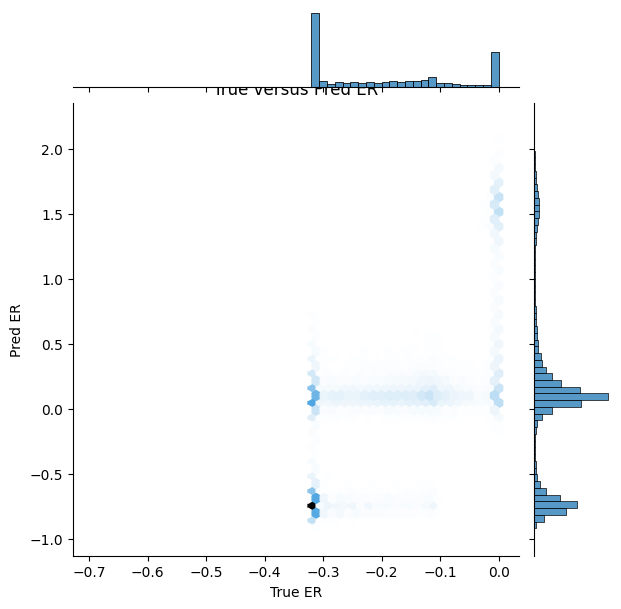

In [8]:
import seaborn as sns


# sns.jointplot(x=mdm2_y_test[:, 1], y=mdm2_y_test[:, 2],kind='hex')
sns.jointplot(x=y_raw[:, 0], y=mdm2_pred[:, 0], kind='hex')
plt.xlabel('True ER')
plt.ylabel('Pred ER')
plt.title('True versus Pred ER')

In [10]:
mdm2_pred.numpy()[:10].mean(axis=0)

array([ 1.7600567, -2.3144994, -1.7195671], dtype=float32)

In [3]:
import seaborn as sns
import plotly.graph_objects as go

def plot_relations(x_idx, y_idx, mdm2_ordering, mdm2_pred=mdm2_pred, vals=['Pval','FC', 'ER']):
    # sns.jointplot(x=mdm2_pred[:, x_idx], y=mdm2_pred[:, y_idx]) # , kind='hex'
    fig = go.Figure([go.Scatter(
        x=mdm2_pred[:, x_idx],
        y=mdm2_pred[:, y_idx],
        text=peptides,
        mode="markers",
        # textposition='top right',
        # textfont=dict(color='#E58606'),
        # mode='lines+markers+text',
        # marker=dict(color='#5D69B1', size=8),
        # line=dict(color='#52BCA3', width=1, dash='dash'),
    )])


    # plt.xlabel('Pred ' + vals[x_idx])
    # plt.ylabel('Pred '+ vals[y_idx])
    # plt.title('Predicted vals')

    top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
    plt.scatter(
        x=mdm2_pred[:, x_idx][top_mdm2_mask],
        y=mdm2_pred[:, y_idx][top_mdm2_mask],
        color="red",
        alpha=0.01,
    )
    fig.show()

mdm2_ordering = []
for pred in mdm2_pred.numpy():
    mdm2_ordering.append(pred[2]) # pred[0] + pred[1] + 
plot_relations(1, 0, mdm2_ordering=mdm2_ordering)

NameError: name 'mdm2_pred' is not defined

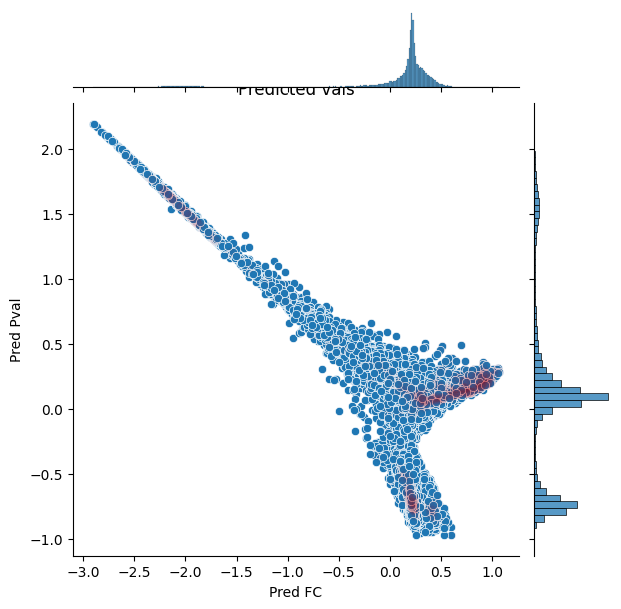

In [12]:

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)
# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=hypothetical_best_mdm2_ordering)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib[[protein_of_interest + idx for idx in REPLICATE_IDXS]].T,


(32944, 14, 37)
MDM2 area under curve:  387.53298069246785
normalized MDM2 area under curve:  0.7750659613849357


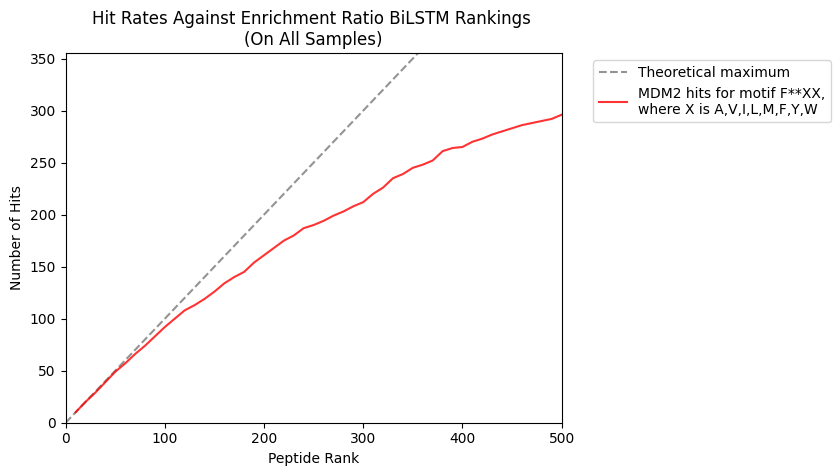

In [127]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_er_train,
        mdm2_y_er_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_only_er_results,
) = experiment.Experiment().run_adhoc_experiment(
    X,
    y_raw[:, 2].reshape(-1,1),
    rnn.SingleRegressionRNN_gelu, #rnn.SingleChannelRegressionRNN, #rnn.ThreeChannelRegressionRNN,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name="mdm_2_ER_only_with_no_cadherin_data_2.h5",#'mdm_2_ER_3.h5',
    other_datasets=[
        peptides,
    ],
    normalize=True
)
mdm2_er_model = mdm2_only_er_results.trained_model
only_er_volcano_mdm2_ordering = np.squeeze([pred_val for pred_val in mdm2_er_model(X)])
print(X.shape)
mdm2_ordering = only_er_volcano_mdm2_ordering

plot_ratio_by_ranking(
    peptides=peptides,#mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,#np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On All Samples)",
    plot_theoretical_maximums=True,
)


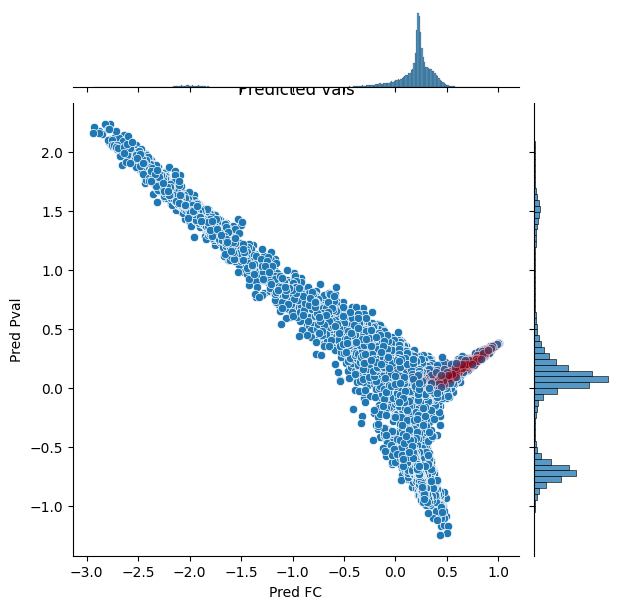

In [142]:

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=np.squeeze(mdm2_er_model(X).numpy()))